In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [1]:
import os
import re
import time
from contextlib import contextmanager
from io import BytesIO
from glob import glob
import random
from shutil import copyfile
from PIL import Image
import json

import torch
from torch import nn, Tensor
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152
from torch.utils.data import DataLoader
from torchvision import transforms as T
from ray import tune

from dataloader import XPlaneVideoDataset, custom_collate_fn
from ram_dataloader import RAMXPlaneVideoDataset
from parquet_dataloader import ParquetXPlaneVideoDataset, Group1ParquetXPlaneVideoDataset
from chunk_dataloader import ChunkXPlaneVideoDataset
import sqlite3 as sql

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-07-06 14:52:52.907160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 14:52:53.589238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = tune.ExperimentAnalysis(Path("~/ray_results/training_xplane5").expanduser()).dataframe()
idx = np.argmin(df["objective"].to_numpy())
model_path = Path(df.iloc[idx]["logdir"]) / "model.pt"
copyfile(model_path, Path("~/best_xplane_model.pt").expanduser())

model = resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.weight.shape[-1], 3)
model.conv1 = nn.Sequential(nn.BatchNorm2d(3), model.conv1)
model.to(device)
model.load_state_dict(torch.load(Path("~/best_xplane_model.pt").expanduser()))
model.eval();

/home/rdyro/.pyenv/versions/devel/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rdyro/.pyenv/versions/devel/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
df.iloc[idx][[k for k in df.columns if "config" in k]].to_dict()

{'config/batch_size': 16,
 'config/lr': 0.0001,
 'config/lr_step': 0.3,
 'config/opt': 'Adam'}

In [ ]:
files = list(glob("/mnt/Storage2/xplane_recording3/*"))
print(f"Total files: {len(files)}")
for file in files:
    print(ChunkXPlaneVideoDataset.estimate_ram_required([file]) / 1e9, "GB")
    transform = T.Compose([T.Lambda(lambda x: x.permute(2, 0, 1)), T.Resize((360, 480))])
    ds = ChunkXPlaneVideoDataset([file], transform=transform, output_full_data=True)
    if ds.data_files == 0:
        continue
    video_name = ds[0][1]["video_name"]
    idx = len(ds)
    frames = [ds[i][0] for i in tqdm(range(idx - 20))]
    states = torch.tensor([ds[i][1]["state"][:3] for i in range(idx - 20)]).to(torch.float32)
    state_exp_list = []
    for frame in tqdm(frames):
        with torch.no_grad():
            state_exp = model(frame[None, ...].to(device).to(torch.float32))[0, ...]
            state_exp_list.append(state_exp.cpu())
    states_exp = torch.stack(state_exp_list) * torch.tensor([1e3, 1e3, 1e2])
    Path(f"data/states_exp_{video_name}.json").write_text(
        json.dumps({"states_pred": states_exp.numpy().tolist(), "states": states.numpy().tolist()})
    )

# Analyze state errors

In [7]:
comparison = [json.loads((Path("data") / Path(f)).read_text()) for f in os.listdir("data")]
comparison = [
    dict(states=torch.tensor(c["states"]), states_pred=torch.tensor(c["states_pred"]))
    for c in comparison
]
fnames = [Path(f).with_suffix("") for f in os.listdir("data")]
losses = [torch.nn.functional.mse_loss(c["states"], c["states_pred"]).item() for c in comparison]
idx = np.argsort(losses)
comparison = [comparison[i] for i in idx]
losses = [losses[i] for i in idx]
fnames = [re.search("recording_[0-9]+.avi", str(fnames[i])).group() for i in idx]

In [8]:
from pprint import pprint

pprint(
    [
        (str(Path(f"~/datasets/xplane_recording2/{fname}").expanduser()), f"{loss:.4e}")
        for fname, loss in zip(fnames[-10:], losses[-10:])
    ]
)

[('/home/rdyro/datasets/xplane_recording2/recording_453271.avi', '9.9143e+04'),
 ('/home/rdyro/datasets/xplane_recording2/recording_706065.avi', '1.0167e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_215253.avi', '1.1356e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_406083.avi', '1.1805e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_030618.avi', '2.4922e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_452653.avi', '3.8997e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_961155.avi', '5.1306e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_458222.avi', '5.6505e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_586962.avi', '6.1229e+05'),
 ('/home/rdyro/datasets/xplane_recording2/recording_306084.avi', '2.6102e+06')]


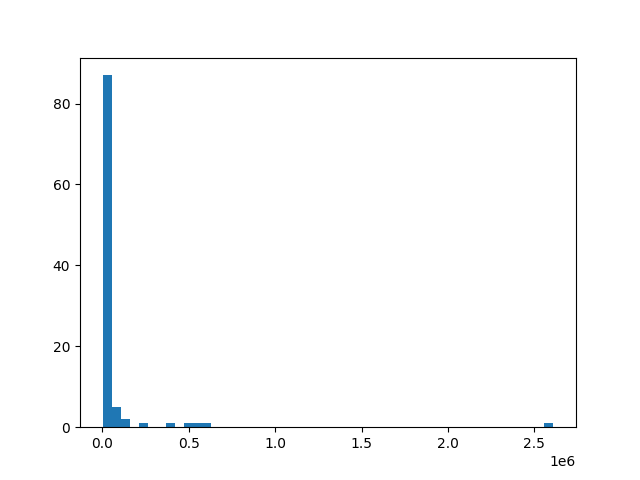

In [10]:
plt.figure()
#plt.hist(losses, bins=50, range=(0, 2e4))
plt.hist(losses, bins=50)
plt.show()

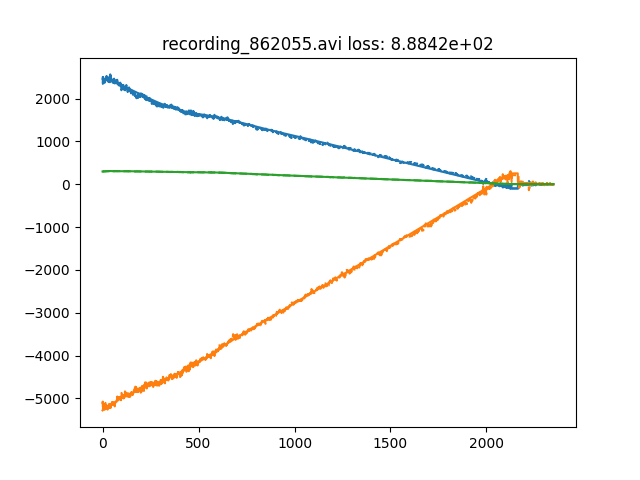

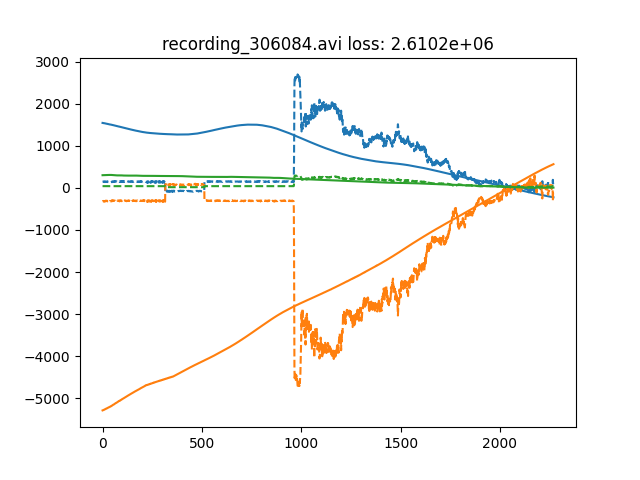

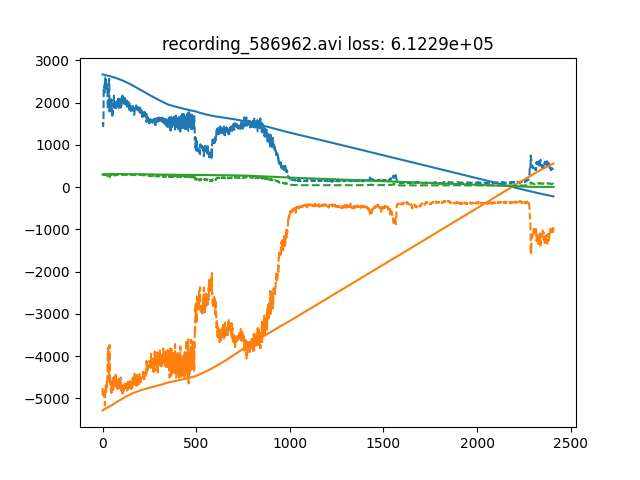

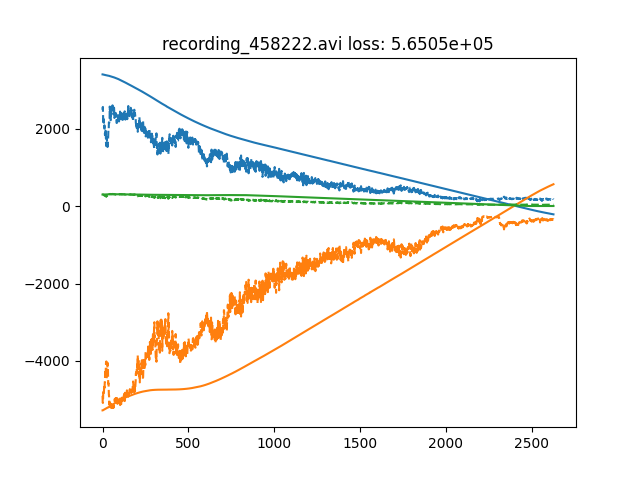

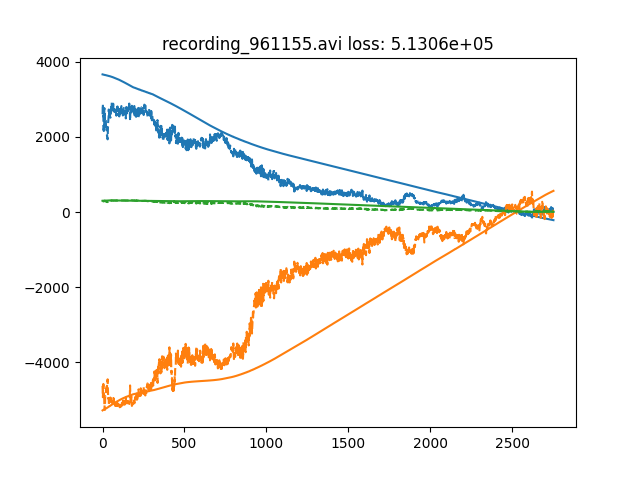

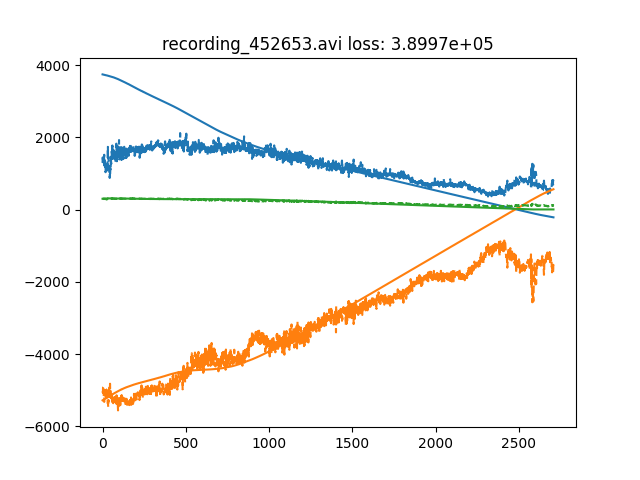

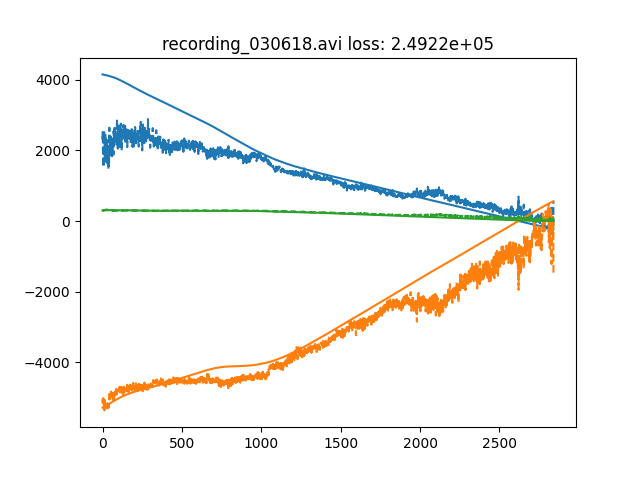

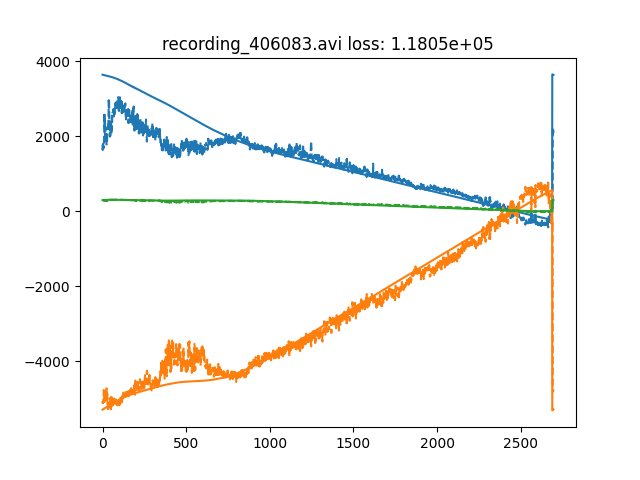

/tmp/ipykernel_193122/2864424175.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


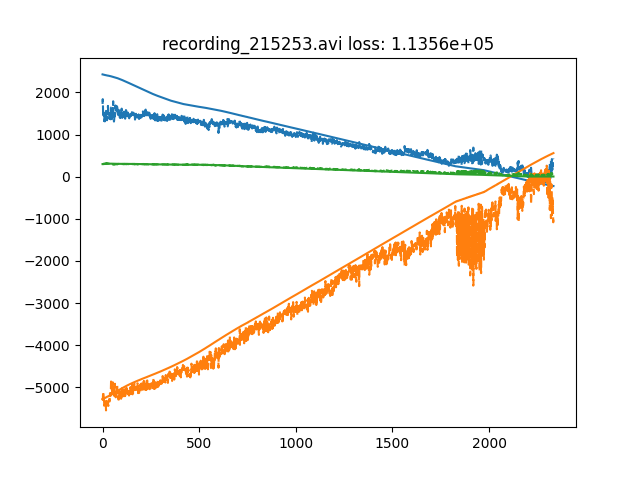

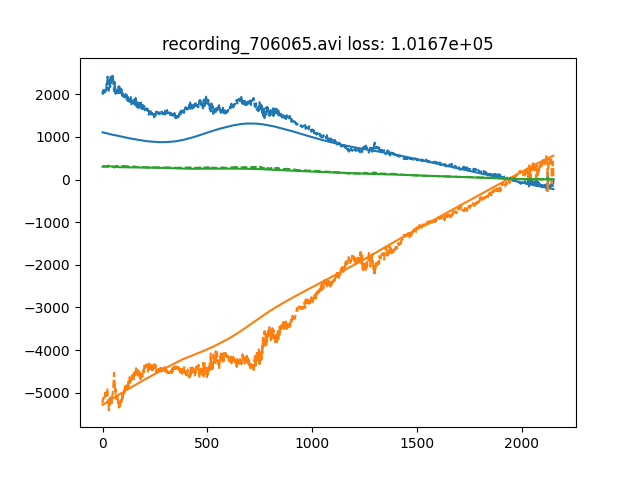

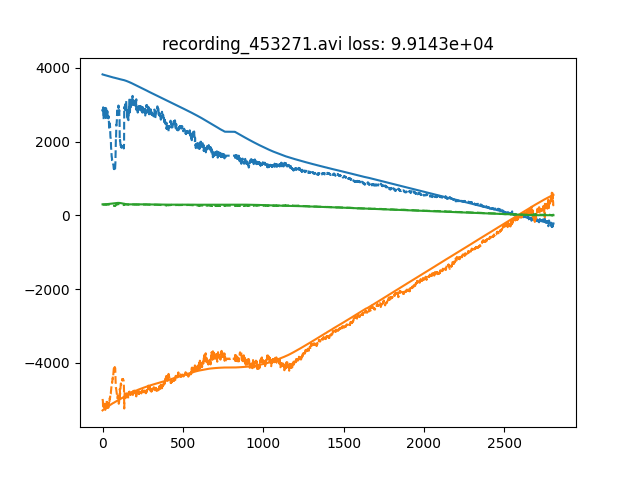

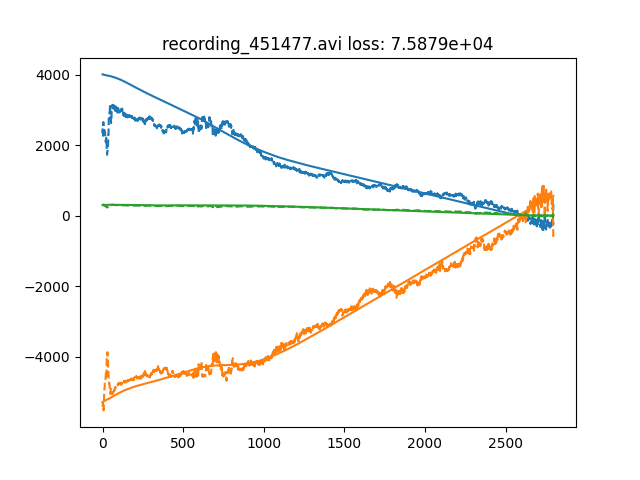

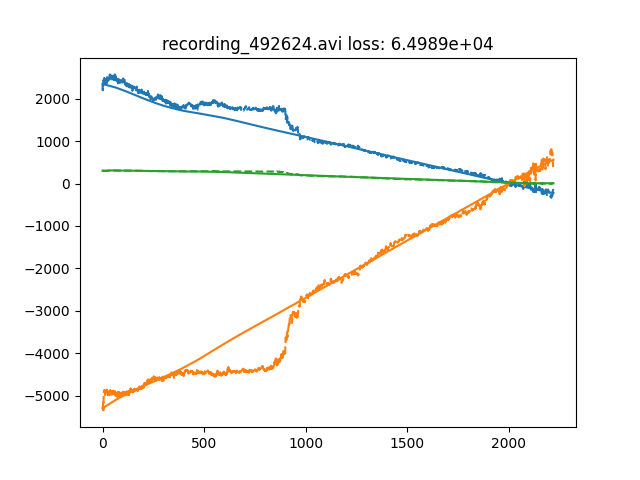

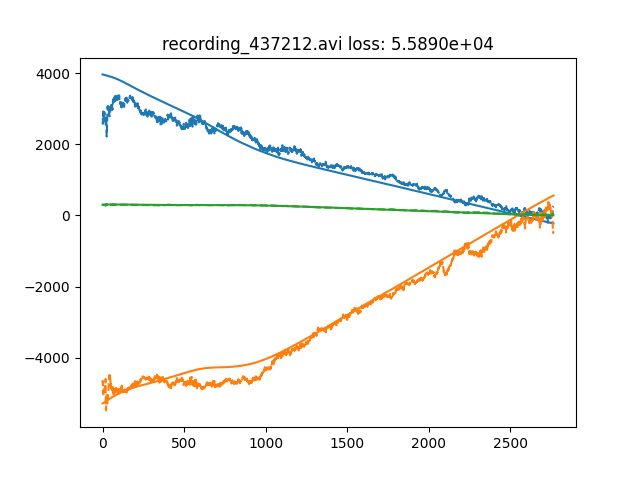

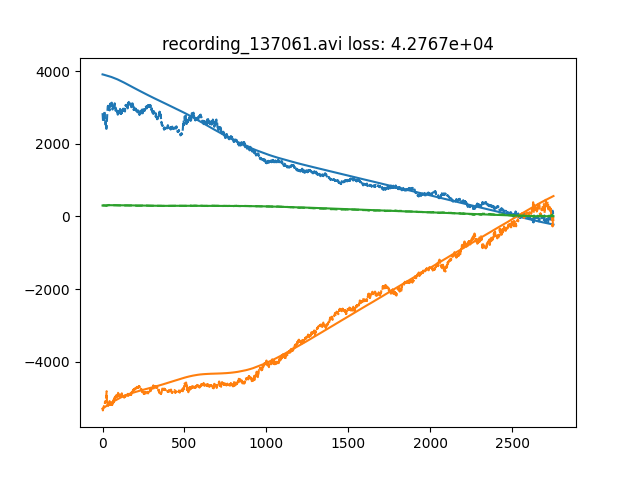

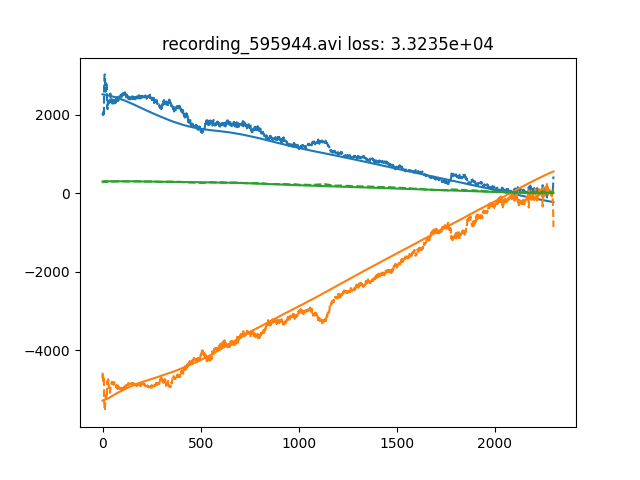

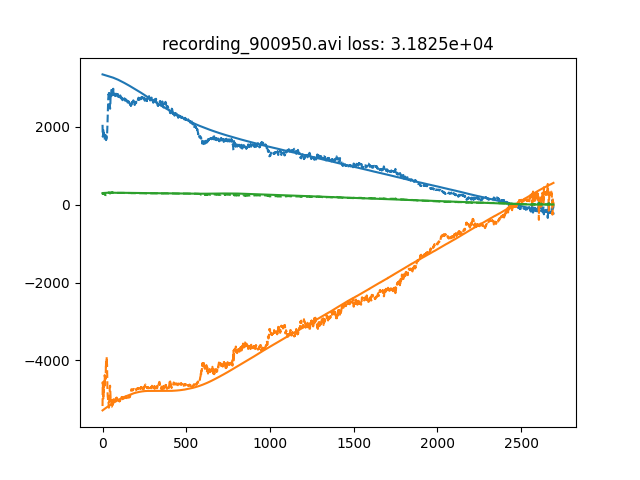

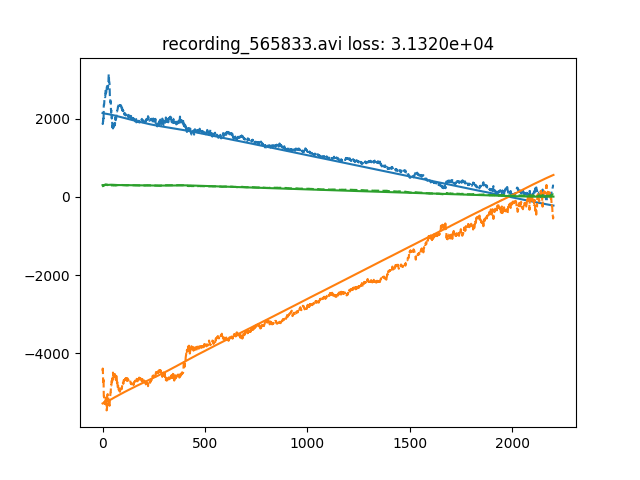

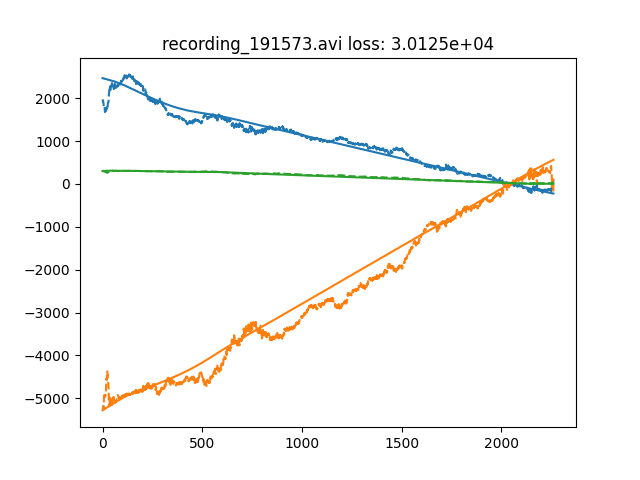

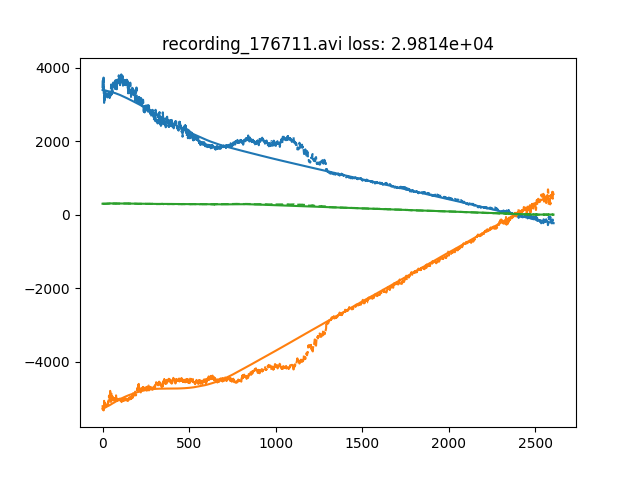

In [12]:
for i in range(20):
    plt.figure()
    plt.title(fnames[-i] + f" loss: {losses[-i]:.4e}")
    for j in range(3):
        plt.plot(comparison[-i]["states"][:, j], label="x", color=f"C{j}")
        plt.plot(comparison[-i]["states_pred"][:, j], label="x", color=f"C{j}", linestyle="--")
    plt.show()

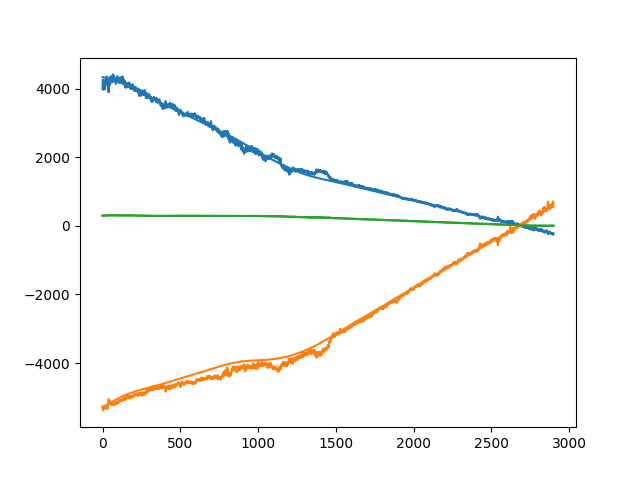

In [ ]:
plt.figure()
plt.plot(states[:, 0].numpy(), label="x")
plt.plot(states[:, 1].numpy(), label="y")
plt.plot(states[:, 2].numpy(), label="z")
plt.plot(state_exp[:, 0].numpy(), label="x", color="C0")
plt.plot(state_exp[:, 1].numpy(), label="y", color="C1")
plt.plot(state_exp[:, 2].numpy(), label="z", color="C2")
plt.show()

In [31]:
state_exp

tensor([[-1.1596,  0.7224,  2.9117],
        [-1.1543,  0.7210,  2.9126],
        [-1.1607,  0.7225,  2.9117],
        ...,
        [-1.1253,  0.7213,  2.8866],
        [-1.0354,  0.6956,  2.8948],
        [-0.9569,  0.6774,  2.8974]])

In [8]:
def custom_collate_fn(batch):
    frames, data, weather = list(zip(*batch))
    state = torch.stack([torch.as_tensor(row["state"]).to(torch.float32) for row in data])
    return torch.stack(frames, 0), state


dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=8, collate_fn=custom_collate_fn)

In [9]:
t = time.time()
for i, (frames, state) in enumerate(dl):
    if i >= 100:
        break
t = (time.time() - t) / 100
print(f"Average time to read a row group: {t:.4e}s")

Average time to read a row group: 1.4361e-01s


In [ ]:
def custom_collate_fn(batch):
    frames, states = tuple(map(list, zip(*batch)))
    return torch.stack(frames), torch.stack(states).to(torch.float32)


# ds = RAMXPlaneVideoDataset(Path("/mnt/Storage2/subset.bin"), transform=None)
ds = ParquetXPlaneVideoDataset(
    Path("/mnt/Storage2/xplane_dataset.parquet"), transform=None, output_full_state=True
)

In [5]:
con = sql.connect("/mnt/Storage2/xplane_dataset.db")
cur = con.cursor()
cur.execute(
    """
CREATE TABLE IF NOT EXISTS xplane_dataset 
(
    id INTEGER PRIMARY KEY,
    video_name TEXT, 
    frame_bytes BLOB, 
    frame_id INTEGER, 
    sim_time REAL, 
    state BLOB, 
    time_of_day TEXT, 
    time_since_midnight REAL, 
    weather_cloud_cover BLOB, 
    weather_cloud_type BLOB, 
    weather_rain_snow_none TEXT, 
    weather_rain_percent REAL
)
"""
)
con.commit()


def tensor2bytes(x: Tensor) -> bytes:
    buf = BytesIO()
    torch.save(torch.as_tensor(x), buf)
    buf.seek(0)
    return buf.read()


#try:
#    for i, prow in tqdm(enumerate(ds), total=len(ds)):
#        row = [
#            i,
#            "uknown",
#            prow["frame_bytes"],
#            prow["frame_id"],
#            prow["sim_time"],
#            tensor2bytes(prow["state"]),
#            prow["time_of_day"],
#            prow["time_since_midnight"],
#            tensor2bytes(prow["weather_cloud_cover"]),
#            tensor2bytes(prow["weather_cloud_type"]),
#            prow["weather_rain_snow_none"],
#            prow["weather_rain_percent"],
#        ]
#        con.execute("INSERT INTO xplane_dataset VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", row)
#finally:
#    con.commit()
#    con.close()

In [7]:
con = sql.connect("/mnt/Storage2/xplane_dataset.db")
cur = con.cursor()
t = time.time()
ridx = np.random.randint(0, len(ds), size=(128,))
msg = "SELECT frame_bytes, state FROM xplane_dataset WHERE id in (%s)" % str(ridx.tolist())[1:-1]
cur.execute(msg)
values = list(cur.fetchall())
print("Elapsed time: %.4e s" % (time.time() - t))
con.close()
#try:
#    t = time.time()
#    for _ in range(100):
#        ridx = np.random.randint(0, len(ds), size=(128,))
#        cur.executemany(f"SELECT frame_bytes, state FROM xplane_dataset WHERE id = ?", ridx.tolist())
#        values = cur.fetchall()
#    print(f"Time taken: {(time.time() - t) / 100:.4e} s")
#finally:
#    con.close()

Elapsed time: 1.5923e+00 s


In [11]:
ds = Group1ParquetXPlaneVideoDataset("/mnt/Storage2/xplane_dataset_gs1.parquet", transform=None)
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=8, collate_fn=custom_collate_fn)

In [13]:
t = time.time()
for i, (frames, states) in tqdm(enumerate(dl), total=100):
    if i >= 100:
        break
print(f"Elapsed time: {(time.time() - t) / 100:.4e} s")

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Elapsed time: 5.6966e-01 s


In [ ]:
dl = DataLoader(
    ds, batch_size=128, num_workers=8, shuffle=True, collate_fn=custom_collate_fn
)
t = time.time()
for i, (X, state) in tqdm(enumerate(dl), total=len(dl)):
    if i > 100:
        break
print(f"Time: {(time.time() - t) / 1e2:.4e} s")


In [5]:
model = resnet101(pretrained=False)
model.fc = nn.Linear(model.fc.weight.shape[-1], 3)
model.conv1 = nn.Sequential(nn.BatchNorm2d(3), model.conv1)
model.to(device);

/home/rdyro/.pyenv/versions/devel/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rdyro/.pyenv/versions/devel/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
step_lr = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.3)
loss_fn = nn.MSELoss()
norm_factor = torch.tensor([1e3, 1e3, 1e2], device=device)
writer = SummaryWriter()

In [7]:
for epoch in range(10):
    pbar = tqdm(dl, total=len(dl))
    for i, (X, Y) in enumerate(pbar):
        optimizer.zero_grad()
        X, Y = X.to(device).to(torch.float32), Y.to(device)
        Y = Y[:, :3] / norm_factor
        loss = loss_fn(model(X), Y)
        loss.backward()
        pbar.set_description(f"Loss: {loss.item():.4e}")
        optimizer.step()
        writer.add_scalar("Loss", loss.item(), i + epoch * len(dl))
        writer.flush()
    step_lr.step()

  0%|          | 0/1812 [00:00<?, ?it/s]

Loss: 1.9680e-01:  17%|█▋        | 304/1812 [02:28<12:15,  2.05it/s]


KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), Path("/mnt/Storage2/model.pth"))

In [ ]:
model.eval()